In [0]:
from google.colab import drive 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import pandas as pd
from joblib import load
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
cd '/gdrive/My Drive/Colab Notebooks/Knight ML Assignment/Data/mydata'

/gdrive/My Drive/Colab Notebooks/Knight ML Assignment/Data/mydata


In [0]:
nb_model=load('nb_numerical_features.joblib')

In [0]:
rd_model=load('svm_review_description.joblib')

In [0]:
rt_model=load('svm_review_title.joblib')

In [0]:
rd_tfidf=load('tfidf_review_description.joblib')

In [0]:
rt_tfidf=load('tfidf_review_title.joblib')

In [0]:
country_encoder= load('country_encoder.joblib')
points_encoder= load('points_encoder.joblib')

In [0]:
df=pd.read_csv('df2_train.csv')[['country', 'review_title', 'review_description', 'points',
       'province', 'variety']]

In [0]:
id_to_category = load('label_dictionary.joblib')

In [0]:
df.head()

,country,review_title,review_description,points,province,variety
0,France,Château Haut la Pointe 2016 Blaye Côtes de Bo...,"This ripe young wine, with its blueberry aroma...",87,Bordeaux,Bordeaux-style Red Blend
1,US,Michael David 2009 Lust Zinfandel (Lodi),"Nothing small about this wine. A super-dark, r...",85,California,Zinfandel
2,Italy,Masseto 2011 Merlot (Toscana),"A rich, ripe expression of one of Italy's icon...",94,Tuscany,Merlot
3,US,Bridlewood 2011 Blend 175 Red (Central Coast),"A blend of Syrah, Cabernet Sauvignon, Viognier...",85,California,Red Blend
4,US,La Crema 1998 Zinfandel (Sonoma County),"Smooth style, with lots of vanilla cream and r...",86,California,Zinfandel


In [0]:
rd_features = rd_tfidf.transform(df.review_description).toarray()

In [0]:
labels=df.variety

In [0]:
labels

0        Bordeaux-style Red Blend
1                       Zinfandel
2                          Merlot
3                       Red Blend
4                       Zinfandel
                   ...           
40694                       Gamay
40695              Gewürztraminer
40696             Sauvignon Blanc
40697                    Nebbiolo
40698                       Syrah
Name: variety, Length: 40699, dtype: object

In [0]:
rd_features = pd.Series(rd_model.predict(rd_features)).map(id_to_category)

In [0]:
rd_features = rd_features.apply(lambda x: 'rd_'+x)

In [0]:
rd_features = pd.get_dummies(rd_features,drop_first=True)

In [0]:
rt_features=rt_tfidf.transform(df.review_title).toarray()

In [0]:
rt_features = pd.Series(rt_model.predict(rt_features)).map(id_to_category)

In [0]:
rt_features = rt_features.apply(lambda x: 'rt_'+x)

In [0]:
rt_features = pd.get_dummies(rt_features,drop_first=True)

In [0]:
rt_features

,rt_Bordeaux-style White Blend,rt_Cabernet Franc,rt_Cabernet Sauvignon,rt_Champagne Blend,rt_Chardonnay,rt_Gamay,rt_Gewürztraminer,rt_Grüner Veltliner,rt_Malbec,rt_Merlot,rt_Nebbiolo,rt_Pinot Grigio,rt_Pinot Gris,rt_Pinot Noir,rt_Portuguese Red,rt_Portuguese White,rt_Red Blend,rt_Rhône-style Red Blend,rt_Riesling,rt_Rosé,rt_Sangiovese,rt_Sauvignon Blanc,rt_Sparkling Blend,rt_Syrah,rt_Tempranillo,rt_White Blend,rt_Zinfandel
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40694,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40695,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
40697,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
nb_features  = df[['points','country']]

In [0]:
nb_features=pd.concat([pd.DataFrame(points_encoder.transform(df[['points']])),pd.DataFrame(country_encoder.transform(df[['country']]))],axis=1)

In [0]:
features = pd.concat([rd_features,rt_features,nb_features],axis=1)

In [0]:
category_to_id = load('category_to_id.joblib')

In [0]:
labels=labels.map(category_to_id)

Started Training LinearSVC
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Completed Training LinearSVC
Started Training MultinomialNB
Completed Training MultinomialNB


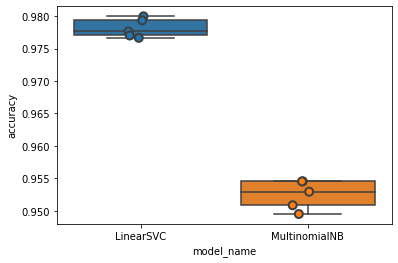

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(verbose=1),
    MultinomialNB(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  print("Started Training {}".format(model_name))
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
  print("Completed Training {}".format(model_name))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC        0.978132
MultinomialNB    0.952480
Name: accuracy, dtype: float64

In [0]:
category_id_df = load('category_id_df.joblib')

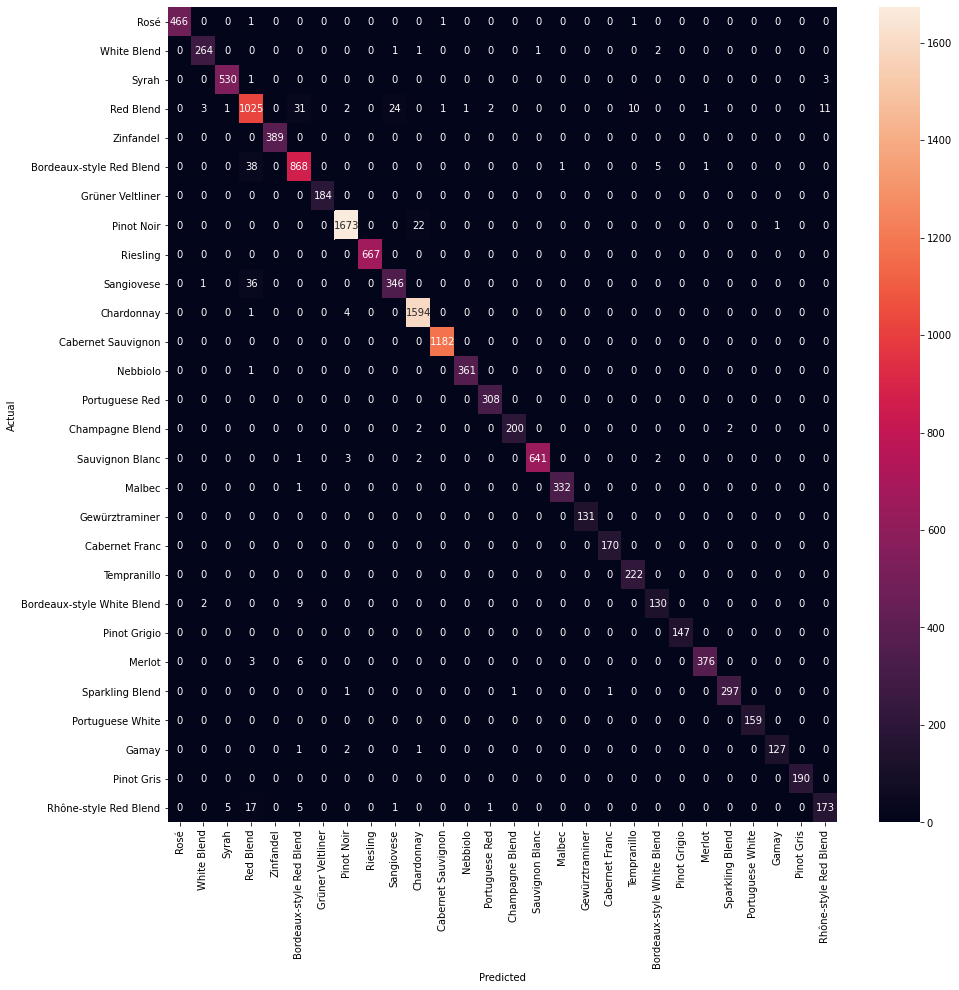

In [0]:
from sklearn.model_selection import train_test_split
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['variety'].unique()))

                            precision    recall  f1-score   support

  Bordeaux-style Red Blend       1.00      0.99      1.00       469
                 Zinfandel       0.98      0.98      0.98       269
                    Merlot       0.99      0.99      0.99       534
                 Red Blend       0.91      0.92      0.92      1112
                Pinot Noir       1.00      1.00      1.00       389
                  Riesling       0.94      0.95      0.95       913
          Portuguese White       1.00      1.00      1.00       184
                Chardonnay       0.99      0.99      0.99      1696
           Sauvignon Blanc       1.00      1.00      1.00       667
                      Rosé       0.93      0.90      0.92       383
        Cabernet Sauvignon       0.98      1.00      0.99      1599
                Sangiovese       1.00      1.00      1.00      1182
                Pinot Gris       1.00      1.00      1.00       362
                  Nebbiolo       0.99      1.00